In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import re
import gensim.downloader as api

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Uncomment if necessary
# pip install wordcloud
# pip install sentence_transformers

In [3]:
# import preproccessed csv file
df = pd.read_csv('preprocessed_amazon.csv')

In [4]:
# Tokenization and Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Title'])

In [5]:
# Tokenization and Vectorization using Word2Vec
tokenized_text = [word_tokenize(text) for text in df['Product Title']]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [6]:
# Averaging Word2Vec vectors for each tokenized Title
X_word2vec = []
for text in tokenized_text:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        X_word2vec.append(np.mean(vectors, axis=0))
    else:
        X_word2vec.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no valid words found

X_word2vec = np.array(X_word2vec)

In [7]:
# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using Word2Vec vectors
knn_word2vec = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_word2vec.fit(X_word2vec)

NearestNeighbors(metric='cosine', n_neighbors=15)

In [8]:
def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'word2vec':
        words = word_tokenize(input_text)
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if len(word_vectors) == 0:
            return []
        input_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector, n_neighbors=top_k)
    elif vectorizer == 'word2vec':
        _, indices = knn_word2vec.kneighbors(input_vector, n_neighbors=top_k)
    
    return df.iloc[indices[0]]['Product Title'].tolist()

# Test
input_text = "pore cleanser"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_word2vec = find_similar_posts(input_text, 'word2vec', knn_word2vec)

print("Similar posts using TF-IDF:")
for idx, post in enumerate(similar_posts_tfidf, start=1):
    print(f"{idx}. {post}")
    
print("\nSimilar posts using Word2Vec:")
for idx, post in enumerate(similar_posts_word2vec, start=1):
    print(f"{idx}. {post}")

Similar posts using TF-IDF:
1.  Epielle Deep Pore Charcoal Cleanser 
2.  [TOSOWOONG] Heating gel pore brush/pore care/pore brush/remove blackhead 
3.  Beauty Formulas Deep Action Pore Cleanser 150ml 
4.  Avon Clear Skin Pore & Shine Control Gel Cleanser 125ml 
5.  Electric Facial Pore Cleanser BlackHead Cleaner Acne Removal Vacuum Suction 

Similar posts using Word2Vec:
1.  MAC pearlmatte face powder IN FOR A TREAT ~ Baking Beauties Collection 
2.  Style anti aging hair mask hair loss control 100ml 
3.  Schwarzkopf Schauma silicone free care shampoo 400ml 
4.  toppic black hair fiber 
5.  Generic Florid 36 colors temporary hair dye kit/non-toxic hair chalk/Easy to use soft pastel /Multi-purpose s hair color crayons 


In [9]:
glove_model = api.load('glove-wiki-gigaword-100')

# Fit the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Title'])

# Fit the KNN model using TF-IDF vectors
knn_tfidf = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf.fit(X_tfidf)

# Fit the KNN model using GloVe vectors
def get_glove_vector(word):
    try:
        return glove_model[word]
    except KeyError:
        return None

def get_mean_glove_vectors(words):
    vectors = [get_glove_vector(word) for word in words]
    vectors = [vec for vec in vectors if vec is not None]
    if len(vectors) == 0:
        return None
    return np.mean(vectors, axis=0).reshape(1, -1)

def get_glove_vectorized_data(X):
    vectors = [get_mean_glove_vectors(word_tokenize(str(text))) for text in X['Product Title']]
    valid_vectors = [vec for vec in vectors if vec is not None]
    return np.concatenate(valid_vectors) if valid_vectors else np.array([])

X_glove_array = get_glove_vectorized_data(df)
knn_glove = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove.fit(X_glove_array)

def find_similar_posts(input_text, vectorizer, knn_model, top_k=5):
    if vectorizer == 'tfidf':
        input_vector = tfidf_vectorizer.transform([input_text])
    elif vectorizer == 'glove':
        input_vector = get_mean_glove_vectors(word_tokenize(input_text))
        if input_vector is None:
            return []
    
    if vectorizer == 'tfidf':
        _, indices = knn_tfidf.kneighbors(input_vector)
    elif vectorizer == 'glove':
        _, indices = knn_glove.kneighbors(input_vector)
    
    return df.iloc[indices[0]]['Product Title']
# Test
input_text = "korean facial mask"
similar_posts_tfidf = find_similar_posts(input_text, 'tfidf', knn_tfidf)
similar_posts_glove = find_similar_posts(input_text, 'glove', knn_glove)

print("Similar posts using TF-IDF:")
print(similar_posts_tfidf)
print("\nSimilar posts using GloVe:")
print(similar_posts_glove)


Similar posts using TF-IDF:
6597      Hanvi Hyaluronic Acid Moisturizing Face Mask ...
23059     World Beautys New 2018 Star Glitter Mask Mois...
21316     World Beautys New BIOAQUA 5pcs Face Mask Aloe...
22194     World Beautys New Luxurious Star Glitter Mask...
17063     World Beautys New HEMEIEL Bamboo Charcoal Bub...
20860     Royal Beauty A2 : Deep Moisture Natural Facia...
15316     Royal Beauty Replenishment : BIOAQUA maquiage...
8034      Pinkdose Hyaluronic Acid Face Mask Moisturizi...
10862     Pinkdose Im Real Tony Moly Face Mask Korean S...
6958      Dmask Premium Facial Mask Sheet Korean Skin C...
16041     Generic 5Pcs The Skin Nourishing Mask 5 Boxed...
6588      Royal Beauty BLUE : BIOAQUA Ball mask face ma...
13456     World Beautys New 60g Korean Facial Masks Bla...
20239     Royal Beauty 3 : Facial Mask Collagen Aloe Ol...
20560     Royal Beauty 4 : Facial Mask Collagen Aloe Ol...
Name: Product Title, dtype: object

Similar posts using GloVe:
5651      Christmas pres

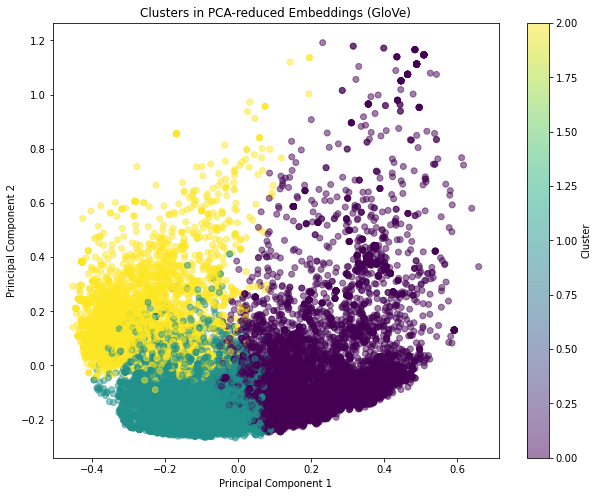

In [10]:
glove_model = api.load('glove-wiki-gigaword-100')

# Vectorize product titles using GloVe embeddings
def get_mean_glove_vector(text):
    words = word_tokenize(text)
    vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else None

X_glove = df['Product Title'].apply(get_mean_glove_vector)
X_glove = np.vstack(X_glove.dropna())

normalized_embeddings = X_glove / np.linalg.norm(X_glove, axis=1, keepdims=True)

kmeans_glove = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_glove = kmeans_glove.fit_predict(normalized_embeddings)

pca_glove = PCA(n_components=3)
compressed_embeddings_glove = pca_glove.fit_transform(normalized_embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(compressed_embeddings_glove[:, 0], compressed_embeddings_glove[:, 1], c=clusters_glove, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Clusters in PCA-reduced Embeddings (GloVe)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

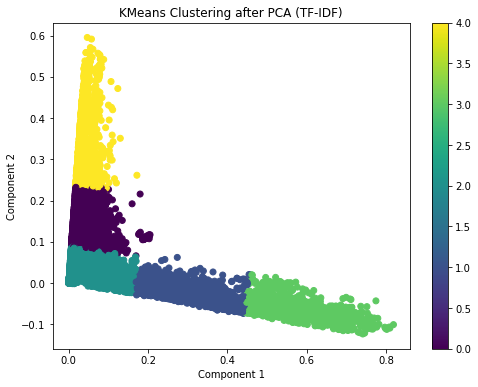

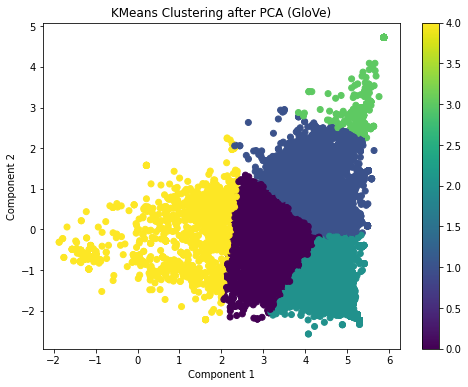

In [11]:
# Perform PCA on TF-IDF vectors
pca = TruncatedSVD(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf)

# Perform PCA on GloVe vectors
X_glove_pca = pca.fit_transform(X_glove)

# Perform KMeans clustering on PCA-transformed TF-IDF vectors
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pca.fit(X_pca)

# Perform KMeans clustering on PCA-transformed GloVe vectors
kmeans_glove_pca = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_glove_pca.fit(X_glove_pca)

# Visualize the clusters for PCA-transformed TF-IDF vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (TF-IDF)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Visualize the clusters for PCA-transformed GloVe vectors
plt.figure(figsize=(8, 6))
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], c=kmeans_glove_pca.labels_, cmap='viridis')
plt.title('KMeans Clustering after PCA (GloVe)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

In [12]:
pd.set_option('display.max_colwidth', None)

# Fit the TruncatedSVD (PCA) model
pca = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Fit the KNN model on the PCA-transformed TF-IDF vectors
knn_tfidf_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf_pca.fit(X_tfidf_pca)

# Define a function to find similar posts using PCA-transformed TF-IDF vectors
def find_similar_posts_tfidf_pca(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    input_pca = pca.transform(input_vector)
    _, indices = knn_tfidf_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed TF-IDF vectors
input_text = "purple phonecase"
similar_posts_tfidf_pca = find_similar_posts_tfidf_pca(input_text)
print("Similar posts using TF-IDF after PCA:")
print(similar_posts_tfidf_pca)

Similar posts using TF-IDF after PCA:
10896                                                                                              Kaiv Lof2206 Double Color Sponge, Multicolor, 80 g 
960                                                                                                                    SUGARIN Fondust, Purple, 5.5gm 
1842                                                                            Leemax Disposable Surgical Bouffant Shower Caps, 50 Pcs (Multi-color) 
476                                         SWEET INSPIRATIONS Edible Cake decoration Sprinkle cupcake toppers Multi Color Flower Vein LARGE - 25 pcs 
21319                                                                                                          SUGARIN Whipping Color,Navy Blue, 28GM 
4441           Generic 02: Magic Color Jelly AB Diamond DIY Nails Rhinestones Flat Back Non Hotfix Rhinestones stickers Need Glue Nail Art Decoration 
22914                                                   

In [13]:
pd.set_option('display.max_colwidth', None)

# Fit the TruncatedSVD (PCA) model
pca = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Fit the KNN model on the PCA-transformed TF-IDF vectors
knn_tfidf_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf_pca.fit(X_tfidf_pca)

# Define a function to find similar posts using PCA-transformed TF-IDF vectors
def find_similar_posts_tfidf_pca(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    input_pca = pca.transform(input_vector)
    _, indices = knn_tfidf_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed TF-IDF vectors
input_text = "korean facial mask" 
similar_posts_tfidf_pca = find_similar_posts_tfidf_pca(input_text)
print("Similar posts using TF-IDF after PCA:")
print(similar_posts_tfidf_pca)

Similar posts using TF-IDF after PCA:
1267                                                                                                         Marcifaire Silver Facial Mask 
14885                                                                         MIRABELLE COSMETICS KOREA Wine Fairness Facial Sheet Mask EX 
17864                                                                                           Dermactin Ts Facial Sheet Mask Brightening 
3439                                                                     Earth Therapeutics - Nourishing Avocado Facial Sheet Mask 3 Count 
6505      Dosoger Whitening Massager LED 7 Colors Light Microcurrent Facial Mask Machine Photon Therapy Skin Rejuvenation Facial Neck Mask 
7698                                             SLB Works 10pcs Cosmetic Spatula Plastic Home DIY Facial Mask Sticks Spoons Travel Access 
19483                                                                     KKY Water Ice Levin Glitter Star Mask Bling Faci

In [14]:
pd.set_option('display.max_colwidth', None)

# Fit the TruncatedSVD (PCA) model
pca = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_pca = pca.fit_transform(X_tfidf)

# Fit the KNN model on the PCA-transformed TF-IDF vectors
knn_tfidf_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_tfidf_pca.fit(X_tfidf_pca)

# Define a function to find similar posts using PCA-transformed TF-IDF vectors
def find_similar_posts_tfidf_pca(input_text, top_k=15):
    input_vector = tfidf_vectorizer.transform([input_text])
    input_pca = pca.transform(input_vector)
    _, indices = knn_tfidf_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

# Example usage for PCA-transformed TF-IDF vectors
input_text = "pore cleanser" 
similar_posts_tfidf_pca = find_similar_posts_tfidf_pca(input_text)
print("Similar posts using TF-IDF after PCA:")
print(similar_posts_tfidf_pca)

Similar posts using TF-IDF after PCA:
13013                                                                                                                    Cicamed Cleanser Antioxidant 
3627                                                                                                                         Secura Personal Cleanser 
8721                                                                                                              Earth Science A-D-E Creamy Cleanser 
12632                                                                                                 Biotherm Homme Aquapower Cleanser- 125ml/4.22oz 
10135                                                                                                     Dr. Schrammek Deep Pore Cleanser Regulating 
4617                                                                                                   Aveeno Clear Complexion Foaming Cleanser, 180g 
5193                                                    

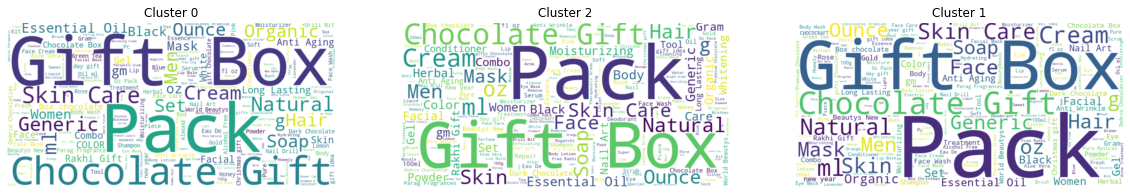

In [15]:
# Create a wordcloud
cluster_texts_glove = defaultdict(str)
for text, label in zip(df['Product Title'], clusters_glove):
    cluster_texts_glove[label] += " " + text

plt.figure(figsize=(20, 10))
for i, (label, text) in enumerate(cluster_texts_glove.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(1, len(cluster_texts_glove), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {label}')
    plt.axis("off")
plt.show()

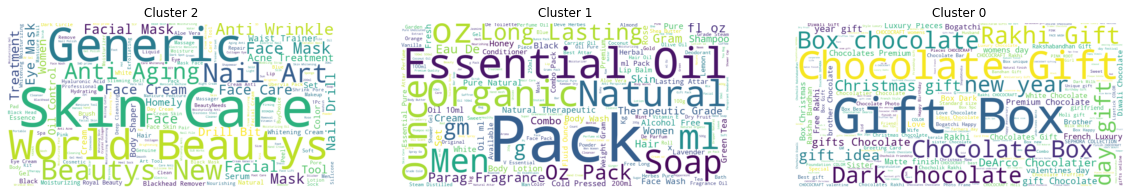

In [25]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

# Define a function to get the mean Word2Vec vector for a given text
def get_mean_word2vec_vector(text):
    tokens = word_tokenize(text)
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return sum(vectors) / len(vectors) if vectors else None

# Vectorize the product titles using Word2Vec
X_word2vec = df['Product Title'].apply(get_mean_word2vec_vector)
X_word2vec = X_word2vec.dropna()

# Combine the Word2Vec vectors into a single vector for the entire text
all_word2vec_vectors = sum(X_word2vec)
mean_word2vec_vector = all_word2vec_vectors / len(X_word2vec)

# Get the word frequencies for the Word2Vec vectors
word_freq = {word: count for word, count in word2vec_model.wv.key_to_index.items()}

# Create a dictionary to store text for each cluster
cluster_texts_word2vec = defaultdict(str)
for text, label in zip(df['Product Title'], clusters_word2vec):
    cluster_texts_word2vec[label] += " " + text

# Create word clouds for each cluster
plt.figure(figsize=(20, 10))
for i, (label, text) in enumerate(cluster_texts_word2vec.items(), 1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(1, len(cluster_texts_word2vec), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {label}')
    plt.axis("off")
plt.show()


In [18]:
# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

def get_mean_glove_vectors(words):
    vectors = [glove_model[word] for word in words if word in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector of the same dimension as the GloVe vectors
    return np.mean(vectors, axis=0)

# Vectorize the entire dataset using GloVe embeddings
X_glove = np.array([get_mean_glove_vectors(word_tokenize(text)) for text in df['Product Title']])
X_glove = np.nan_to_num(X_glove)  # Handle NaN values

# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Fit the KNN model on the PCA-transformed GloVe vectors
knn_glove_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove_pca.fit(X_glove_pca)

# Define a function to find similar posts using PCA-transformed GloVe vectors
def find_similar_posts_glove_pca(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    input_vector = input_vector.reshape(1, -1)  
    input_pca = pca_glove.transform(input_vector)
    _, indices = knn_glove_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

input_text = "purple phonecase"
similar_posts_glove_pca = find_similar_posts_glove_pca(input_text)
print("\nSimilar posts using GloVe after PCA:")
print(similar_posts_glove_pca)


Similar posts using GloVe after PCA:
16199                                    New Popular Facial Face Steamer Pores Cleanser Mist Steam Sprayer Spa Sauna Skin Vaporizer color blue Hot Selling 
15862            Generic 3D Sleep Mask Natural Sleeping Eye Mask Eyeshade Cover Shade Eye Patch Women Men Soft Portable Blindfold Travel Eyepatch Rose red 
1437         Homely OldLace Short Color Full Cover Artificial Nails Flat Matte Pure Simple Salon False Nail Easy DIY Salon Manicure Tool Z959 : pink matte 
18187                                                                BAW sky blue : 1Pc Wash Face Makeup SPA Hair Band Womens Sweat Elastic Soft headbands 
20424                  World Beautys New Pro Blackhead Remove Facial Masks Deep Cleansing Purifying Peel Off Black Nude Facial Face black Mask Face Beauty 
14596                              BeautyNeeds 1Pair Moisturize Soften Repair Cracked Skin Gel Sock Skin Foot Care Tool Treatment Spa Sock with pink Color 
13508           Generic Cl

In [20]:
# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

def get_mean_glove_vectors(words):
    vectors = [glove_model[word] for word in words if word in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector of the same dimension as the GloVe vectors
    return np.mean(vectors, axis=0)

# Vectorize the entire dataset using GloVe embeddings
X_glove = np.array([get_mean_glove_vectors(word_tokenize(text)) for text in df['Product Title']])
X_glove = np.nan_to_num(X_glove)  # Handle NaN values

# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Fit the KNN model on the PCA-transformed GloVe vectors
knn_glove_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove_pca.fit(X_glove_pca)

# Define a function to find similar posts using PCA-transformed GloVe vectors
def find_similar_posts_glove_pca(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    input_vector = input_vector.reshape(1, -1)  
    input_pca = pca_glove.transform(input_vector)
    _, indices = knn_glove_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

input_text = "korean facial mask"
similar_posts_glove_pca = find_similar_posts_glove_pca(input_text)
print("\nSimilar posts using GloVe after PCA:")
print(similar_posts_glove_pca)


Similar posts using GloVe after PCA:
6588                                                                               Royal Beauty BLUE : BIOAQUA Ball mask face mask facial treatment mask hydrating mask 
10043                   World Beautys New Brand 24K golden mask Anti wrinkle anti aging facial mask face care whitening face masks skin care face lifting firming Masks 
18735                                    Atoz prime 5pcs facial mask sheet whitening skin lifting face masks face care anti aging wrinkle pig nose masker beauty agless 
9981                       Royal Beauty WETCODE mermaids facial mask magic deep moisture hydrating mask moisturizing face mask care Depth Replenishment easily absorbed 
1953                                   Generic suction black mask deep cleansing nose blackhead remover facial mask black head acne black mud face mask beauty skincare 
4279                               Hanvi korea dark circle hydrogel eye patch 60pcs hydrolyzed collagen gold crystal 

In [21]:
# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

def get_mean_glove_vectors(words):
    vectors = [glove_model[word] for word in words if word in glove_model]
    if len(vectors) == 0:
        return np.zeros(100)  # Return a zero vector of the same dimension as the GloVe vectors
    return np.mean(vectors, axis=0)

# Vectorize the entire dataset using GloVe embeddings
X_glove = np.array([get_mean_glove_vectors(word_tokenize(text)) for text in df['Product Title']])
X_glove = np.nan_to_num(X_glove)  # Handle NaN values

# Perform PCA on the GloVe vectors
pca_glove = TruncatedSVD(n_components=50, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Fit the KNN model on the PCA-transformed GloVe vectors
knn_glove_pca = NearestNeighbors(n_neighbors=15, metric='cosine')
knn_glove_pca.fit(X_glove_pca)

# Define a function to find similar posts using PCA-transformed GloVe vectors
def find_similar_posts_glove_pca(input_text, top_k=15):
    input_vector = get_mean_glove_vectors(word_tokenize(input_text))
    input_vector = input_vector.reshape(1, -1)  
    input_pca = pca_glove.transform(input_vector)
    _, indices = knn_glove_pca.kneighbors(input_pca)
    return df.iloc[indices[0]]['Product Title']

input_text = "pore cleanser"
similar_posts_glove_pca = find_similar_posts_glove_pca(input_text)
print("\nSimilar posts using GloVe after PCA:")
print(similar_posts_glove_pca)


Similar posts using GloVe after PCA:
5677                 Generic Hankey Water Moisturizing Silk Face Mask Skin Care acne Treatment Whitening Deep Moisturizing Wrinkle Anti-Aging Shrink pores 
16738                                                               SWD Prime calendula cream acne repair anti-inflammatory sensitive moisten moisturizing 
11229          World Beautys New Aloe vera gel whitening moisturizing Repair after-sun acne anti-aging anti-inflammatory relieving itching removes pigment 
13805                                            World Beautys New Arrival 1pcs Beauty Red Pomegranate Deep moisturizer Facial Cream Skin Repair Whitening 
8929                                                                                            Avon Solution scrub cleanser For Her+beauty+milkwhite+100g 
19950                                                                                            origins ginzing energy-boosting gel moisturizer 1oz/30 ub 
1538              World Be

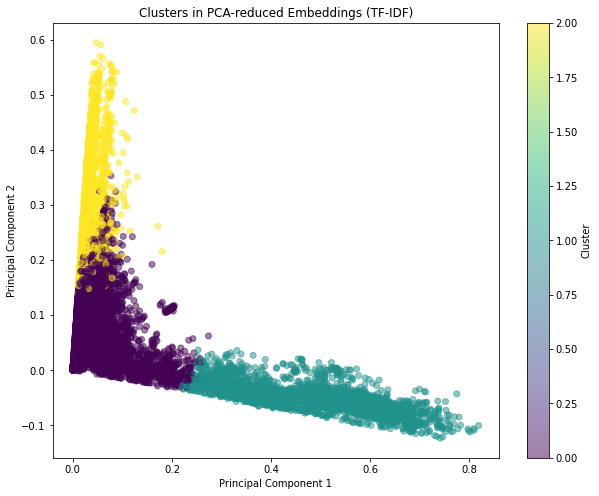

In [22]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Product Title'])

kmeans_tfidf = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_tfidf = kmeans_tfidf.fit_predict(X_tfidf)

pca_tfidf = TruncatedSVD(n_components=2, random_state=42)
compressed_embeddings_tfidf = pca_tfidf.fit_transform(X_tfidf)

plt.figure(figsize=(10, 8))
plt.scatter(compressed_embeddings_tfidf[:, 0], compressed_embeddings_tfidf[:, 1], c=clusters_tfidf, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Clusters in PCA-reduced Embeddings (TF-IDF)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

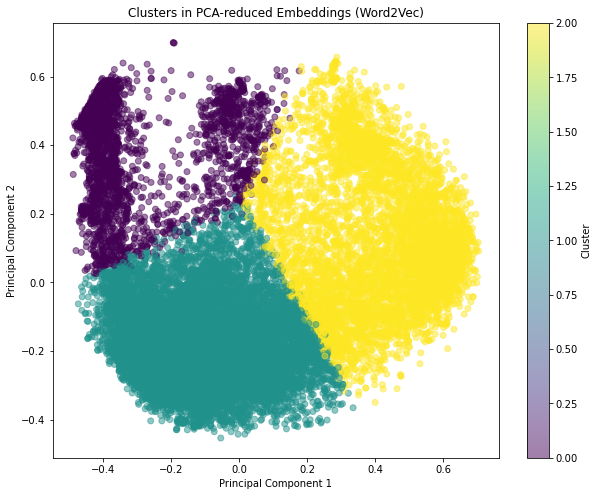

In [23]:
# 1. Tokenization and Word2Vec Vectorization
tokenized_text = [word_tokenize(text) for text in df['Product Title']]
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

def get_mean_word2vec_vector(text):
    words = word_tokenize(text)
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

X_word2vec = np.array([get_mean_word2vec_vector(text) for text in df['Product Title']])

# 2. Normalization
normalized_embeddings_word2vec = X_word2vec / np.linalg.norm(X_word2vec, axis=1, keepdims=True)

# 3. Perform KMeans clustering on normalized Word2Vec vectors
kmeans_word2vec = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters_word2vec = kmeans_word2vec.fit_predict(normalized_embeddings_word2vec)

# 4. Perform PCA on normalized Word2Vec vectors
pca_word2vec = PCA(n_components=2)
compressed_embeddings_word2vec = pca_word2vec.fit_transform(normalized_embeddings_word2vec)

# 5. Visualize the clusters for PCA-transformed Word2Vec vectors
plt.figure(figsize=(10, 8))
plt.scatter(compressed_embeddings_word2vec[:, 0], compressed_embeddings_word2vec[:, 1], c=clusters_word2vec, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.title('Clusters in PCA-reduced Embeddings (Word2Vec)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

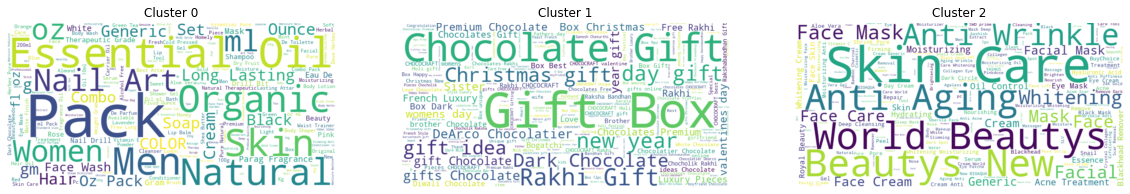

In [24]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

# Define a function to create and display word clouds for each cluster
def create_word_clouds(texts, clusters, n_clusters):
    cluster_texts = defaultdict(str)
    
    # Aggregate texts for each cluster
    for text, cluster in zip(texts, clusters):
        cluster_texts[cluster] += " " + text
    
    # Plot word clouds for each cluster
    plt.figure(figsize=(20, 10))
    for i in range(n_clusters):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_texts[i])
        plt.subplot(1, n_clusters, i+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {i}')
        plt.axis('off')
    plt.show()

# Generate word clouds for each cluster
create_word_clouds(df['Product Title'], clusters_tfidf, n_clusters=3)